# Random Exponential Growth

_(tv) 2016-01-16, 2019-06-12, 2020-06-14, 2023-12-12, 2024-06-10_

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We consider the growth equation $$ dN/dt=r\, N $$ where $r=r_0+\alpha\xi(t)$ is a growth rate composed of a deterministic component $r_0$ and a random term proportional to $\alpha$ and white noise $\xi(t)$. Since this noise multiplies the $N(t)$ term, this defines a SDE with multiplicative noise, and we need to distinguish Itô from Stratonovich calculus. We consider both in order to discuss the differences.

First, a simple Euler-forward scheme to integrate the SDE. You could consider using python packages such as `sdeint` or `sdepy` which offer more advanced integration schemes, but for demonstration purposes, we implement the simplistic algorithm ourselves here. Note that the following algorithm is considered very simplistic (it is known as the Euler-Maruyama method), because its order of convergence is only 0.5 (you need very small time steps). A better method is known as the Milstein scheme.

In [57]:
def integrate_ito(a,b,T,dt,M,x0=0.):
    """ integrate Ito sde up to time T, using timestep dt, generating M samples, initial value x0"""
    N = int(T/dt)
    t = np.linspace(0.,T,N)
    rng = np.random.default_rng()
    sqrtdt = np.sqrt(dt)
    x = np.zeros((N,M))
    x[0,:] = x0
    for i in range(N-1):
        x[i+1,:] = x[i,:] + dt * a(x[i],i*dt) + sqrtdt*rng.standard_normal(M) * b(x[i],i*dt)
    return x

The Euler-Heun method implements the Straonovich scheme (again with very small step size), by updating the stochastic term with a midpoint rule. Note that here it is crucial to do this double update of the stochastic term with a single realization of $dW$, otherwise you're back to Itô.

For a nice summary of these and improved methods of numerically solving SDEs, see [Thomas Schaffter: Numerical Integration of SDEs, A Short Tutorial](https://core.ac.uk/download/pdf/147956299.pdf).

In [74]:
def integrate_stratonovich(a,b,T,dt,M,x0=0.):
    """ integrate Ito sde up to time T, using timestep dt, generating M samples, initial value x0"""
    N = int(T/dt)
    t = np.linspace(0.,T,N)
    rng = np.random.default_rng()
    sqrtdt = np.sqrt(dt)
    x = np.zeros((N,M))
    x[0,:] = x0
    for i in range(N-1):
        dW = rng.standard_normal(M)*sqrtdt
        xbar = x[i,:] + b(x[i],i*dt) * dW
        # key here is to NOT draw a new dW
        #dW = rng.standard_normal(M)*sqrtdt
        x[i+1,:] = x[i,:] + dt * a(x[i],i*dt) + 0.5*(b(x[i],i*dt)+b(xbar,i*dt))*dW
    return x

Let us define the coefficients of the SDE for later use:

In [77]:
def a(x,t):
    return r0*x
def b(x,t):
    return alpha*x

## Low Noise

We first check the difference betwen Itô and Stratonovich in the case where the noise is in some sense "weak". The precise notion comes from the analytical calculation: In Itô interpretation, we have $$ \langle N\rangle(t) \stackrel{\text{It\^o}}= e^{r_0 t} $$ while in Stratonovich interpretation we have $$ \langle N\rangle(t) \stackrel{\text{Str}}= e^{(r_0+\alpha^2/2)t} $$ which grows faster than the Itô mean.

In [78]:
r0 = 1
alpha = 0.2

We generate 5000 samples for each the Itô and the Stratonovich scheme, and plot the numerical mean. For the chosen parameters, this agrees well with the expected analytical results.

In [101]:
x1 = integrate_ito(a, b, 5., 0.001, 5000, x0=1)
y1 = integrate_stratonovich(a, b, 5., 0.001, 5000, x0=1)

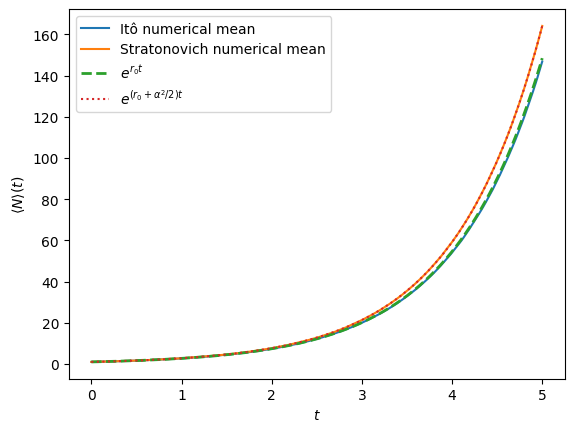

In [102]:
plt.plot(t,np.mean(x1,axis=-1),label='Itô numerical mean')
plt.plot(t,np.mean(y1,axis=-1),label='Stratonovich numerical mean')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashed',label=r'$e^{r_0 t}$')
plt.plot(t,np.exp((r0+alpha*alpha/2)*t),linestyle='dotted',label=r'$e^{(r_0+\alpha^2/2)t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.legend()
plt.show()

It will be instructive to also check the spread of the individual trajectories around the mean: here are the first 100 realizations for Itô (Stratonovich not being qualitatively different).

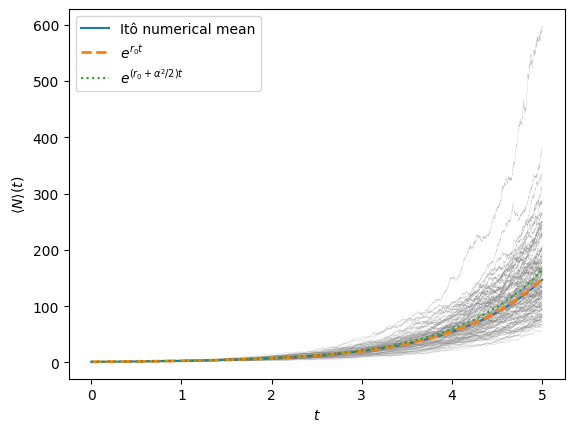

In [103]:
plt.plot(t,x1[:,:100],color='grey',alpha=0.5,linewidth=0.2)
plt.plot(t,np.mean(x1,axis=-1),label='Itô numerical mean')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashed',label=r'$e^{r_0 t}$')
plt.plot(t,np.exp((r0+alpha*alpha/2)*t),linestyle='dotted',label=r'$e^{(r_0+\alpha^2/2)t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.legend()
plt.show()

In [104]:
x1,y1 = None,None # free some memory

## Critical Noise

From the analytical calculation, it appears that $$ \alpha=2\sqrt{r_0} $$ defines a "critical" noise strength. At this point, we expect individual realizations of the Itô process to be dominated by $\exp[\alpha W]$, where $W$ is the Wiener process.

In [217]:
r0 = 1
alpha = np.sqrt(2)

Check what happens now: for the Itô integration, our statistics now seems to be insufficient, and we need to increase the number of samples quite a bit to come closer to the analytical result.

In [218]:
x2 = integrate_ito(a, b, 5., 0.001, 5000, x0=1)
x2b = integrate_ito(a, b, 5., 0.001, 50000, x0=1)
y2 = integrate_stratonovich(a, b, 5., 0.001, 5000, x0=1)

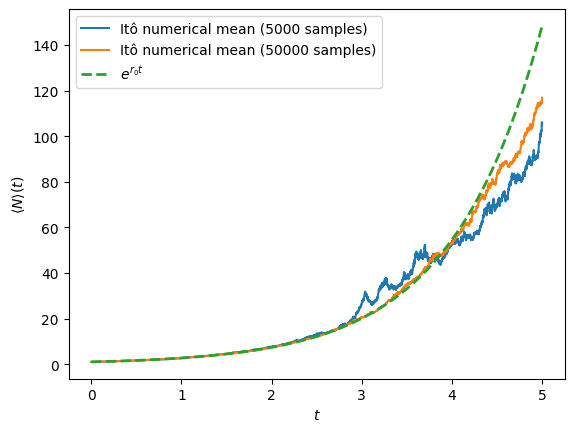

In [219]:
for x in [x2,x2b]:
    plt.plot(t,np.mean(x,axis=-1),label='Itô numerical mean ({} samples)'.format(x[0,:].shape[0]))
#plt.plot(t,np.mean(y2,axis=-1),label='Stratonovich numerical mean')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashed',label=r'$e^{r_0 t}$')
#plt.plot(t,np.exp((r0+alpha*alpha/2)*t),linestyle='dotted',label=r'$e^{(r_0+\alpha^2/2)t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.legend()
plt.show()

The issue comes from the fact that now, individual trajectories show much stronger deviations from the mean, and there are rare paths that deviate exponentially above the mean, and we need to keep enough of those in our sampling (which becomes increasingly hard for increasing time):

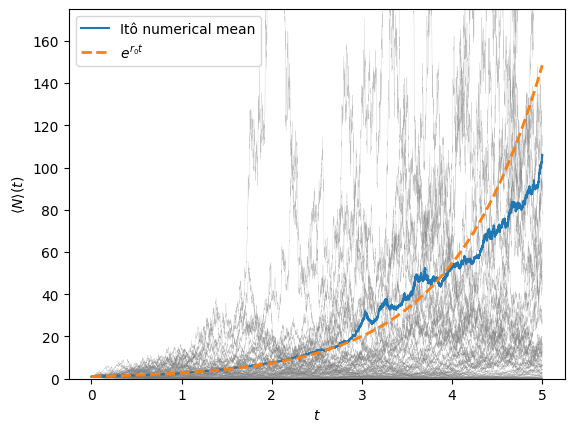

In [220]:
plt.plot(t,x2[:,:100],color='grey',alpha=0.5,linewidth=0.2)
plt.plot(t,np.mean(x2,axis=-1),label='Itô numerical mean')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashed',label=r'$e^{r_0 t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.ylim(0,175)
plt.legend()
plt.show()

A log-log plot shows very instructively what is going on: the individual paths seem to fluctuate around the "most likely" value, which is given by $$ N(t)\simeq e^{(r_0-\alpha^2/2)t} $$ which is, in the critical noise case, simply a constant. But exponentially large deviations to higher values push the mean to an exponentially growing function.

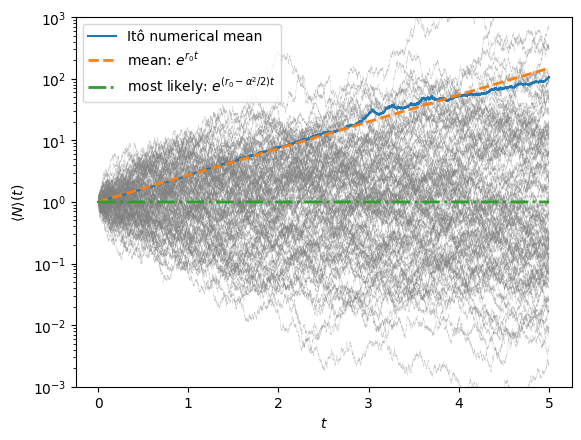

In [221]:
plt.plot(t,x2[:,:100],color='grey',alpha=0.5,linewidth=0.2)
plt.plot(t,np.mean(x2,axis=-1),label='Itô numerical mean')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashed',label=r'mean: $e^{r_0 t}$')
plt.plot(t,np.exp((r0-alpha*alpha/2)*t),linewidth=2,linestyle='dashdot',label=r'most likely: $e^{(r_0-\alpha^2/2)t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.ylim(0.001,1000)
plt.yscale('log')
plt.legend()
plt.show()

For the Stratonovich case, the situation is different: here, we also have to deal with exponentially large deviations, but also the most probably value of the paths grows exponentially in time. Note that, since Stratonovich calculus follows the rules for variable transforms of standard non-stochastic calculus, the expected value here is just $e^{r_0 t}$.

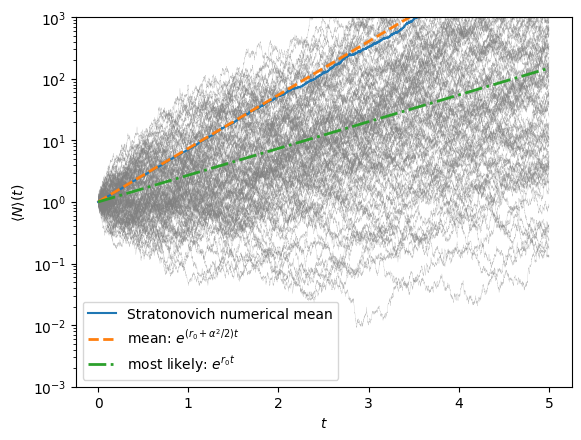

In [224]:
plt.plot(t,y2[:,:100],color='grey',alpha=0.5,linewidth=0.2)
plt.plot(t,np.mean(y2,axis=-1),label='Stratonovich numerical mean')
plt.plot(t,np.exp((r0+alpha*alpha/2)*t),linewidth=2,linestyle='dashed',label=r'mean: $e^{(r_0+\alpha^2/2) t}$')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashdot',label=r'most likely: $e^{r_0 t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.ylim(0.001,1000)
plt.yscale('log')
plt.legend()
plt.show()

The Itô situation is analogous to the toy example of the "random product": Choose numbers $x_-=1/2$ and $x_+=2$ such that $x_-x_+=1$ and form a product where each factor is chosen with equal probability $p_+=p_-=1/2$ from the two factors. Intuition suggest that in the long run, the factors balance each other, but this is only the estimate of the most likely value. The expected mean of the product still diverges exponentially!

In [169]:
choices = [1/2,2]

In [197]:
random_sum = np.sum(rng.choice(np.log(choices),size=(1000,100000)),axis=0)

In [198]:
random_product = np.product(rng.choice(choices,size=(1000,100000)),axis=0)

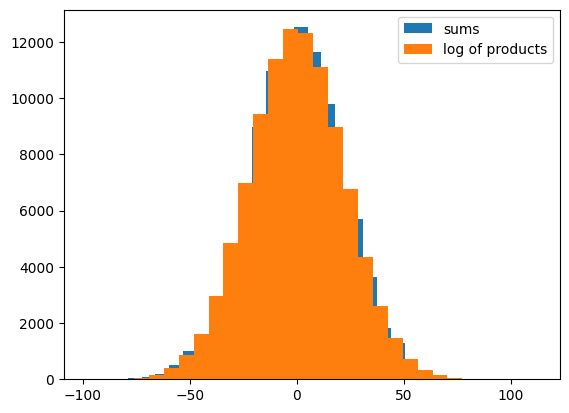

In [208]:
plt.hist(random_sum,bins=30,label='sums')
plt.hist(np.log(random_product),bins=30,label='log of products')
plt.legend()
plt.show()

The analogy is this: we have to be aware that for the product $\Pi$, $$ e^{\ln\langle\Pi\rangle} \gg e^{\langle\ln\Pi\rangle} $$

In [205]:
np.mean(random_product)

5.846006572181565e+43

In [203]:
np.exp(np.mean(random_sum))

0.942562376026881

In [225]:
x2,x2b,y2 = None,None,None

## Strong Noise

Let's push this to a more extreme case, setting a noise amplitude above the critical value. In the Stratonovich case, nothing qualitatively new happens, so we focus on the Itô case.

In [226]:
r0 = 1
alpha = 2

In [227]:
x3 = integrate_ito(a, b, 5., 0.001, 5000, x0=1)
x3b = integrate_ito(a, b, 5., 0.001, 50000, x0=1)

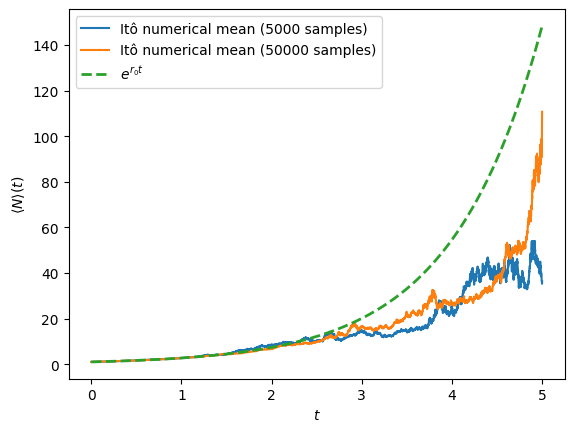

In [228]:
for x in [x3,x3b]:
    plt.plot(t,np.mean(x,axis=-1),label='Itô numerical mean ({} samples)'.format(x[0,:].shape[0]))
#plt.plot(t,np.mean(y2,axis=-1),label='Stratonovich numerical mean')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashed',label=r'$e^{r_0 t}$')
#plt.plot(t,np.exp((r0+alpha*alpha/2)*t),linestyle='dotted',label=r'$e^{(r_0+\alpha^2/2)t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.legend()
plt.show()

The situation is even more striking here: now, the most likely value decays exponentially, i.e., for each realization we expect to draw a time series that decays to zero, while the average over all of them still increases exponentially!

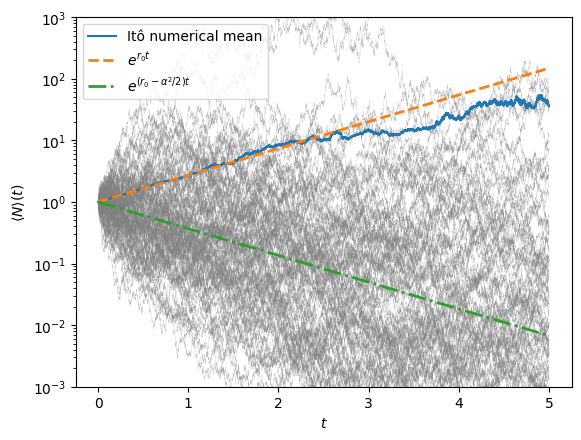

In [229]:
plt.plot(t,x3[:,:100],color='grey',alpha=0.5,linewidth=0.2)
plt.plot(t,np.mean(x3,axis=-1),label='Itô numerical mean')
plt.plot(t,np.exp(r0*t),linewidth=2,linestyle='dashed',label=r'$e^{r_0 t}$')
plt.plot(t,np.exp((r0-alpha*alpha/2)*t),linewidth=2,linestyle='dashdot',label=r'$e^{(r_0-\alpha^2/2)t}$')
plt.xlabel(r'$t$')
plt.ylabel(r'$\langle N\rangle (t)$')
plt.ylim(0.001,1000)
plt.yscale('log')
plt.legend()
plt.show()